In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.utils import class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB4, EfficientNetB7
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


In [2]:
# Directory containing your dataset
data_dir = 'data/data'

# Lists to store image paths and labels
image_paths = []
labels = []

# Loop through each folder
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)

    # Skip non-directory files
    if not os.path.isdir(folder_path):
        continue

    for file in os.listdir(folder_path):
        # Exclude mask files
        if "_mask" not in file:
            file_path = os.path.join(folder_path, file)
            image_paths.append(file_path)
            labels.append(folder)

# Create a DataFrame with images and labels
df = pd.DataFrame({'filepaths': image_paths, 'labels': labels})


In [3]:
# Display the last few rows of the dataframe
df.tail()

filepaths     labels
894  data/data\malignant\malignant (95).png  malignant
895  data/data\malignant\malignant (96).png  malignant
896  data/data\malignant\malignant (97).png  malignant
897  data/data\malignant\malignant (98).png  malignant
898  data/data\malignant\malignant (99).png  malignant

In [1]:
#check the dataset shape
df.shape

NameError: name 'df' is not defined

labels
benign       591
malignant    308
Name: count, dtype: int64


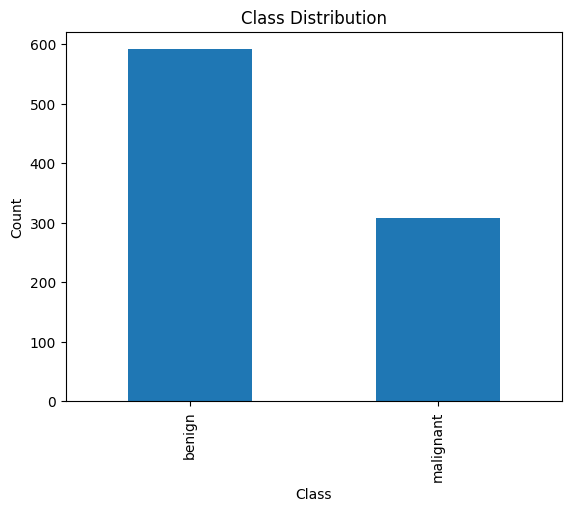

In [5]:
#check the data distribution
class_counts = df['labels'].value_counts()
print(class_counts)

# Visualize
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


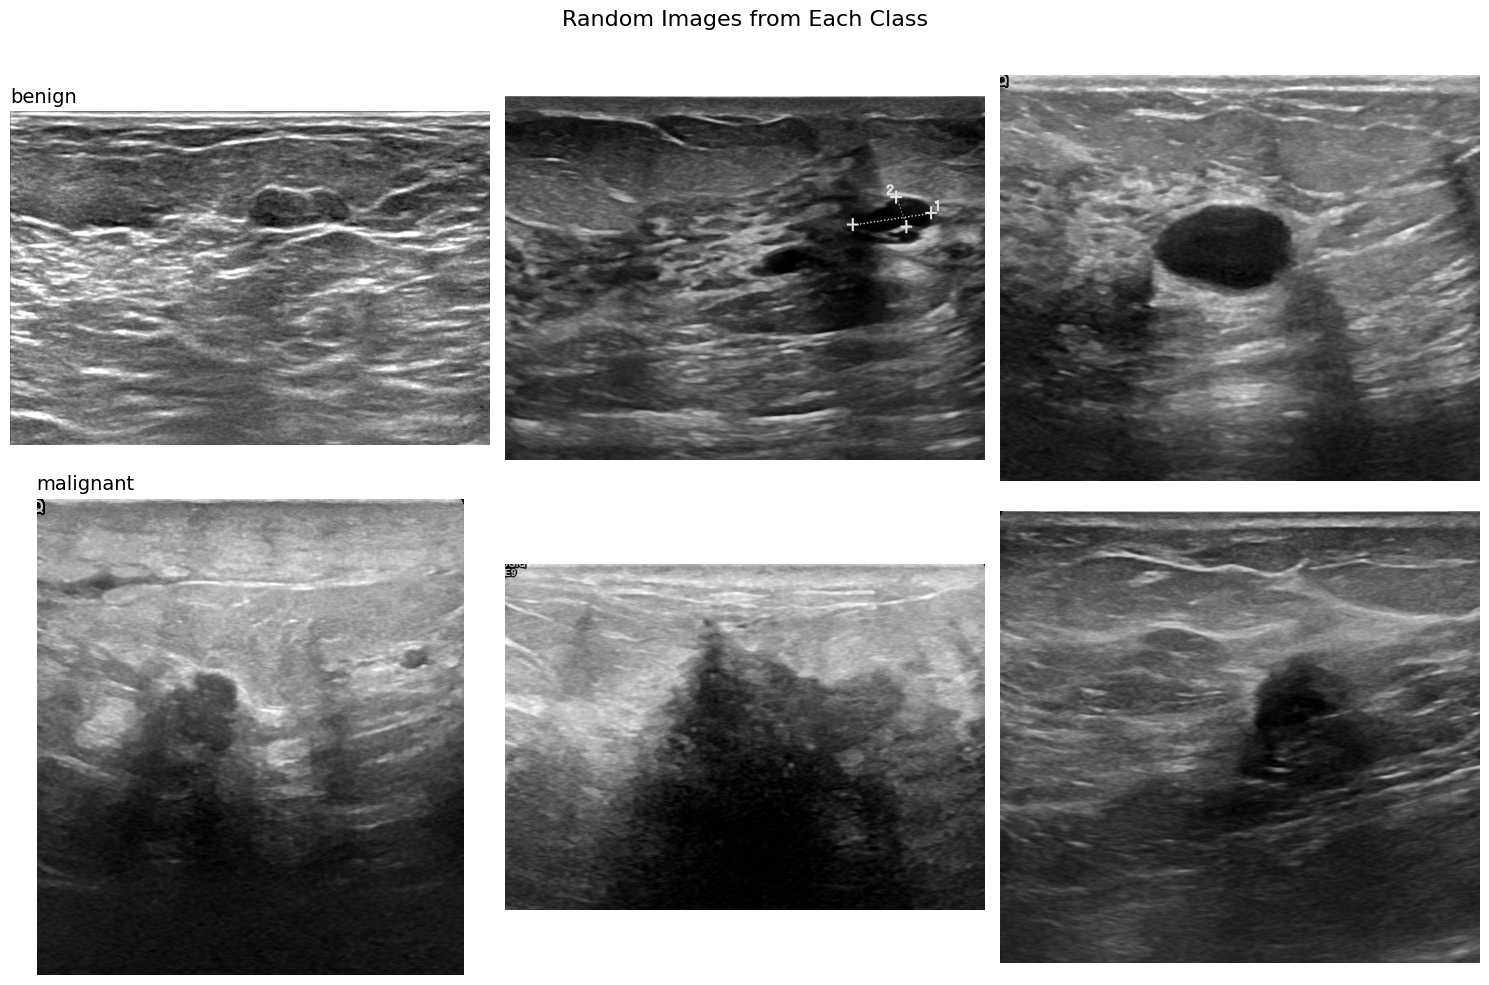

In [6]:
# Function to display random images
def display_random_images(df, num_images=3):
    # Unique labels (classes)
    classes = df['labels'].unique()
    num_classes = len(classes)

    # Set up the plot
    fig, axs = plt.subplots(num_classes, num_images, figsize=(15, 5 * num_classes))
    fig.suptitle('Random Images from Each Class', fontsize=16)

    for i, label in enumerate(classes):
        # Filter the DataFrame for the current label
        class_df = df[df['labels'] == label]

        # Randomly sample images for the current class
        sampled_images = class_df.sample(num_images)['filepaths'].values

        for j, filepath in enumerate(sampled_images):
            # Load and display the image
            img = Image.open(filepath)
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(label, loc='left', fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Call the function with your DataFrame
display_random_images(df, num_images=3)


In [7]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing Values in Dataset:\n", missing_values)


Missing Values in Dataset:
 filepaths    0
labels       0
dtype: int64


In [8]:
# Drop rows with missing filepaths
df_images = df.dropna(subset=['filepaths'])
print("Rows with missing filepaths removed.")


Rows with missing filepaths removed.


In [9]:
#  Assign a default label
df['labels'] = df['labels'].fillna('unknown')

In [10]:
# Remove rows with missing labels
df = df.dropna(subset=['labels'])
print("Rows with missing labels removed.")


Rows with missing labels removed.


In [11]:
# Verify file existence
df['file_exists'] = df['filepaths'].apply(lambda x: os.path.exists(x))
missing_files = df[~df['file_exists']]
print(f"Number of missing files: {len(missing_files)}")

# Remove rows with missing files
df = df[df['file_exists']]
df.drop(columns=['file_exists'], inplace=True)


Number of missing files: 0


In [12]:
# Split into train + temp (temp will be split into validation and test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['labels'],
    random_state=42
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.3,
    stratify=temp_df['labels'],
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 629
Validation set size: 189
Test set size: 81


In [13]:
# Define image generators
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(df['labels'].unique())

# Create an instance of ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and test data, we only rescale the images (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Prepare the data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 629 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 81 validated image filenames belonging to 2 classes.


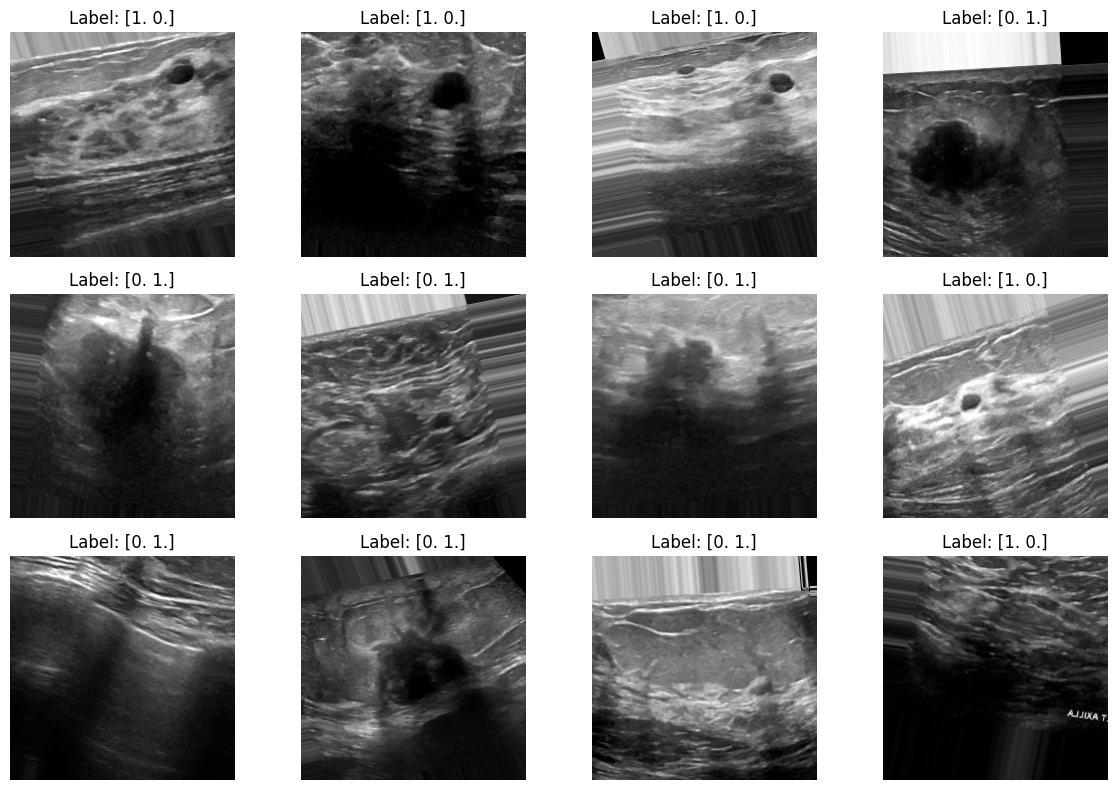

In [14]:
# Fetch a batch of augmented images and labels
augmented_images, augmented_labels = next(train_generator)

# Plot a few augmented images
plt.figure(figsize=(12, 8))
for i in range(12):  # Display 12 augmented images
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title(f"Label: {augmented_labels[i]}")
plt.tight_layout()
plt.show()

Found 899 images belonging to 2 classes.


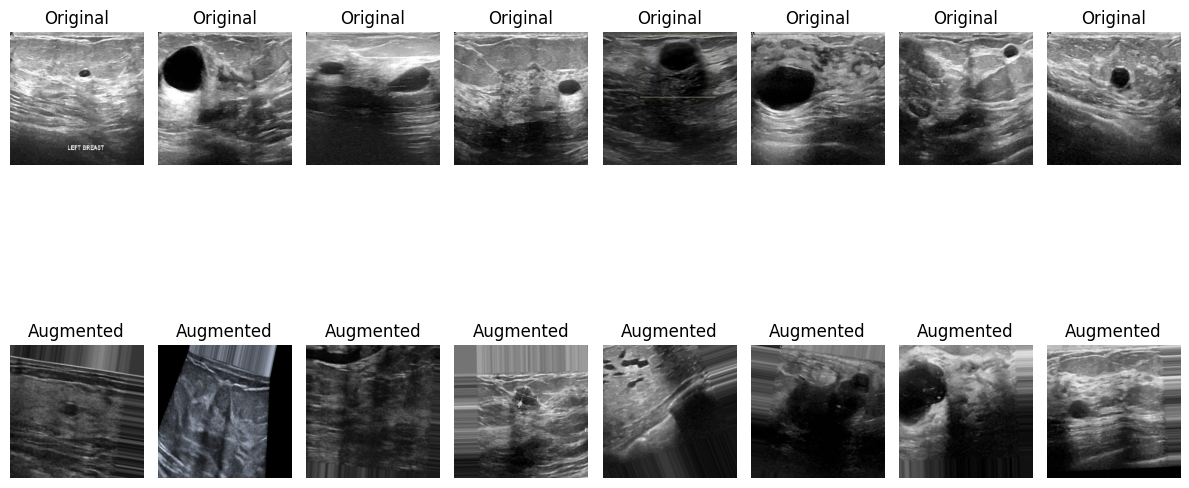

In [15]:
import matplotlib.pyplot as plt

# Create a new generator without augmentation to fetch original images
original_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
original_generator = original_datagen.flow_from_directory(
    "data/data",
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',  # Or 'categorical' depending on your setup
    shuffle=False
)

# Fetch a batch of original images and augmented images
original_images, original_labels = next(original_generator)
augmented_images, augmented_labels = next(train_generator)

# Compare original and augmented images
plt.figure(figsize=(12, 8))
for i in range(8):  # Display 8 images
    # Original image
    plt.subplot(2, 8, i + 1)
    plt.imshow(original_images[i])
    plt.axis('off')
    plt.title("Original")
    
    # Augmented image
    plt.subplot(2, 8, i + 9)
    plt.imshow(augmented_images[i])
    plt.axis('off')
    plt.title("Augmented")
plt.tight_layout()
plt.show()


# Model 1: Densenet 169

In [16]:
# Load DenseNet169 model and unfreeze few top layers
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# without layer unfreezing 
# for layer in base_model.layers:
#   layer.trainable = False

# Freeze all layers except the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Display a summary of the base model to confirm which layers are trainable
base_model.summary()


Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [17]:
# Define model layers on top of the base model

# Create the input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass the input through the base model (DenseNet121)
x = base_model(inputs, training=False)

# Global Average Pooling to reduce the spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# # Batch Normalization for faster training
# x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu')(x)

# Dropout for regularization
x = layers.Dropout(0.5)(x)

# Output layer with softmax activation (for multi-class classification)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
model = models.Model(inputs, outputs)

In [18]:
# Define the optimizer
adamw_optimizer = AdamW(
    learning_rate=0.0001,  # Adjust the learning rate as needed
    weight_decay=1e-5    # Adjust weight decay for regularization
)

# Compile the model
model.compile(
    optimizer=adamw_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               213120    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                             

In [19]:
# The weights are adjusted in order to deal with class imbalance

# Get the labels column
labels = train_df['labels'].values

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Create a dictionary mapping class labels to class weights
class_weight_dict = dict(zip(np.unique(labels), class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {'benign': 0.7596618357487923, 'malignant': 1.4627906976744185}


In [20]:
class_indices = train_generator.class_indices

# Convert your class weights
class_weight_dict = {class_indices['benign']: class_weight_dict['benign'], 
                     class_indices['malignant']: class_weight_dict['malignant']}

In [21]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# Train the model with class weights and early stopping
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Epoch 1/35
20/20 [==============================] - 71s 3s/step - loss: 0.7981 - accuracy: 0.5246 - val_loss: 0.5783 - val_accuracy: 0.7037
Epoch 2/35
20/20 [==============================] - 54s 3s/step - loss: 0.6587 - accuracy: 0.6359 - val_loss: 0.5293 - val_accuracy: 0.7143
Epoch 3/35
20/20 [==============================] - 53s 3s/step - loss: 0.5983 - accuracy: 0.6566 - val_loss: 0.5177 - val_accuracy: 0.7037
Epoch 4/35
20/20 [==============================] - 54s 3s/step - loss: 0.5523 - accuracy: 0.7027 - val_loss: 0.4719 - val_accuracy: 0.7778
Epoch 5/35
20/20 [==============================] - 53s 3s/step - loss: 0.5524 - accuracy: 0.6709 - val_loss: 0.4703 - val_accuracy: 0.7989
Epoch 6/35
20/20 [==============================] - 54s 3s/step - loss: 0.5526 - accuracy: 0.6963 - val_loss: 0.5218 - val_accuracy: 0.7354
Epoch 7/35
20/20 [==============================] - 54s 3s/step - loss: 0.5180 - accuracy: 0.7266 - val_loss: 0.4589 - val_accuracy: 0.8201
Epoch 8/35
20/20 [==

In [22]:
# Evaluate the model

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 [==============================] - 5s 1s/step - loss: 0.4208 - accuracy: 0.8148
Test Loss: 0.4208
Test Accuracy: 0.8148


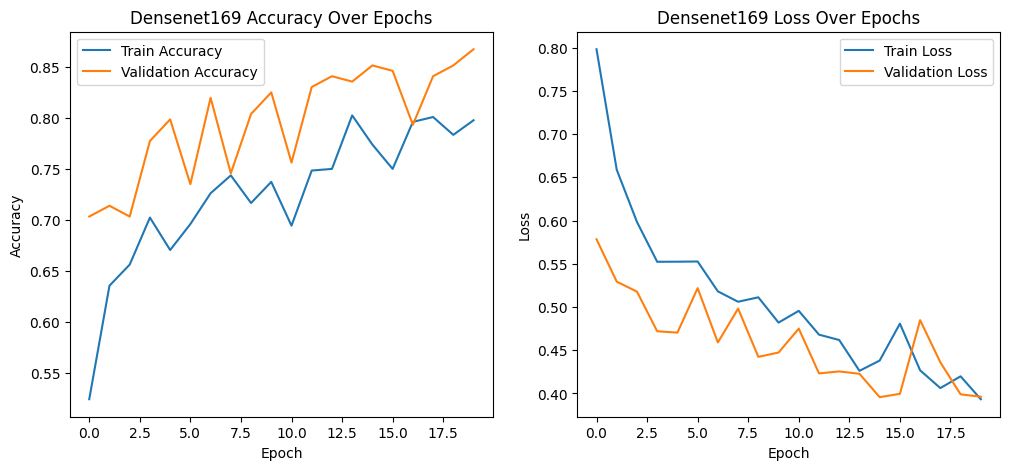

In [23]:

# Plot training vs validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Densenet169 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Densenet169 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


6/6 [==============================] - 14s 2s/step


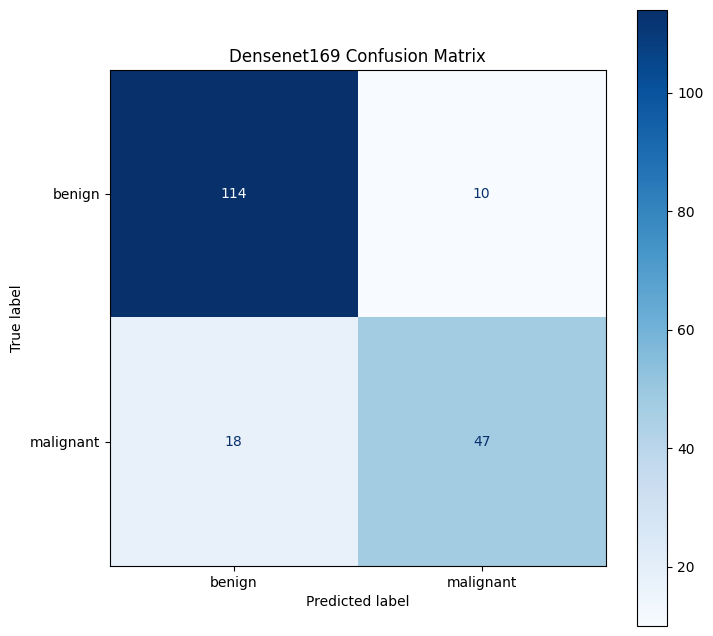

Densenet169 Classification Report:
               precision    recall  f1-score   support

      benign       0.86      0.92      0.89       124
   malignant       0.82      0.72      0.77        65

    accuracy                           0.85       189
   macro avg       0.84      0.82      0.83       189
weighted avg       0.85      0.85      0.85       189



In [24]:

# Predict the labels for the validation data
predictions = model.predict(validation_generator, verbose=1)

# Get the true labels from the validation generator
true_classes = validation_generator.classes

# Convert the predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Define class labels (modify these according to your dataset)
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary
class_labels = [class_labels[i] for i in range(len(class_labels))]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Add title
plt.title('Densenet169 Confusion Matrix')
plt.show()

# Generate and display the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Densenet169 Classification Report:\n", report)


1/1 [==============================] - 0s 179ms/step


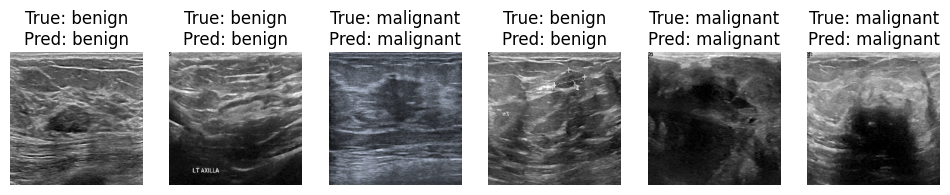

In [25]:
# Display a few predictions

def display_predictions(model, data_generator, num_samples=3):
    # Get a batch of data from the generator
    batch_images, batch_labels = next(data_generator)

    # Randomly select 'num_samples' from the batch
    sample_indices = np.random.choice(batch_images.shape[0], num_samples, replace=False)

    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(sample_indices):
        # Get the image and its true label
        img = batch_images[idx]
        true_label = batch_labels[idx]

        # Predict the label for the image
        pred_prob = model.predict(np.expand_dims(img, axis=0))
        pred_label = np.argmax(pred_prob, axis=1)[0]

        # Convert to class names (if necessary)
        class_names = list(data_generator.class_indices.keys())
        true_label_name = class_names[np.argmax(true_label)]
        pred_label_name = class_names[pred_label]

        # Plot the image and display the true and predicted labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_label_name}\nPred: {pred_label_name}')
        plt.axis('off')

    plt.show()

# Example usage:
display_predictions(model, validation_generator, num_samples=6)


3/3 [==============================] - 5s 1s/step
Number of incorrect predictions: 15


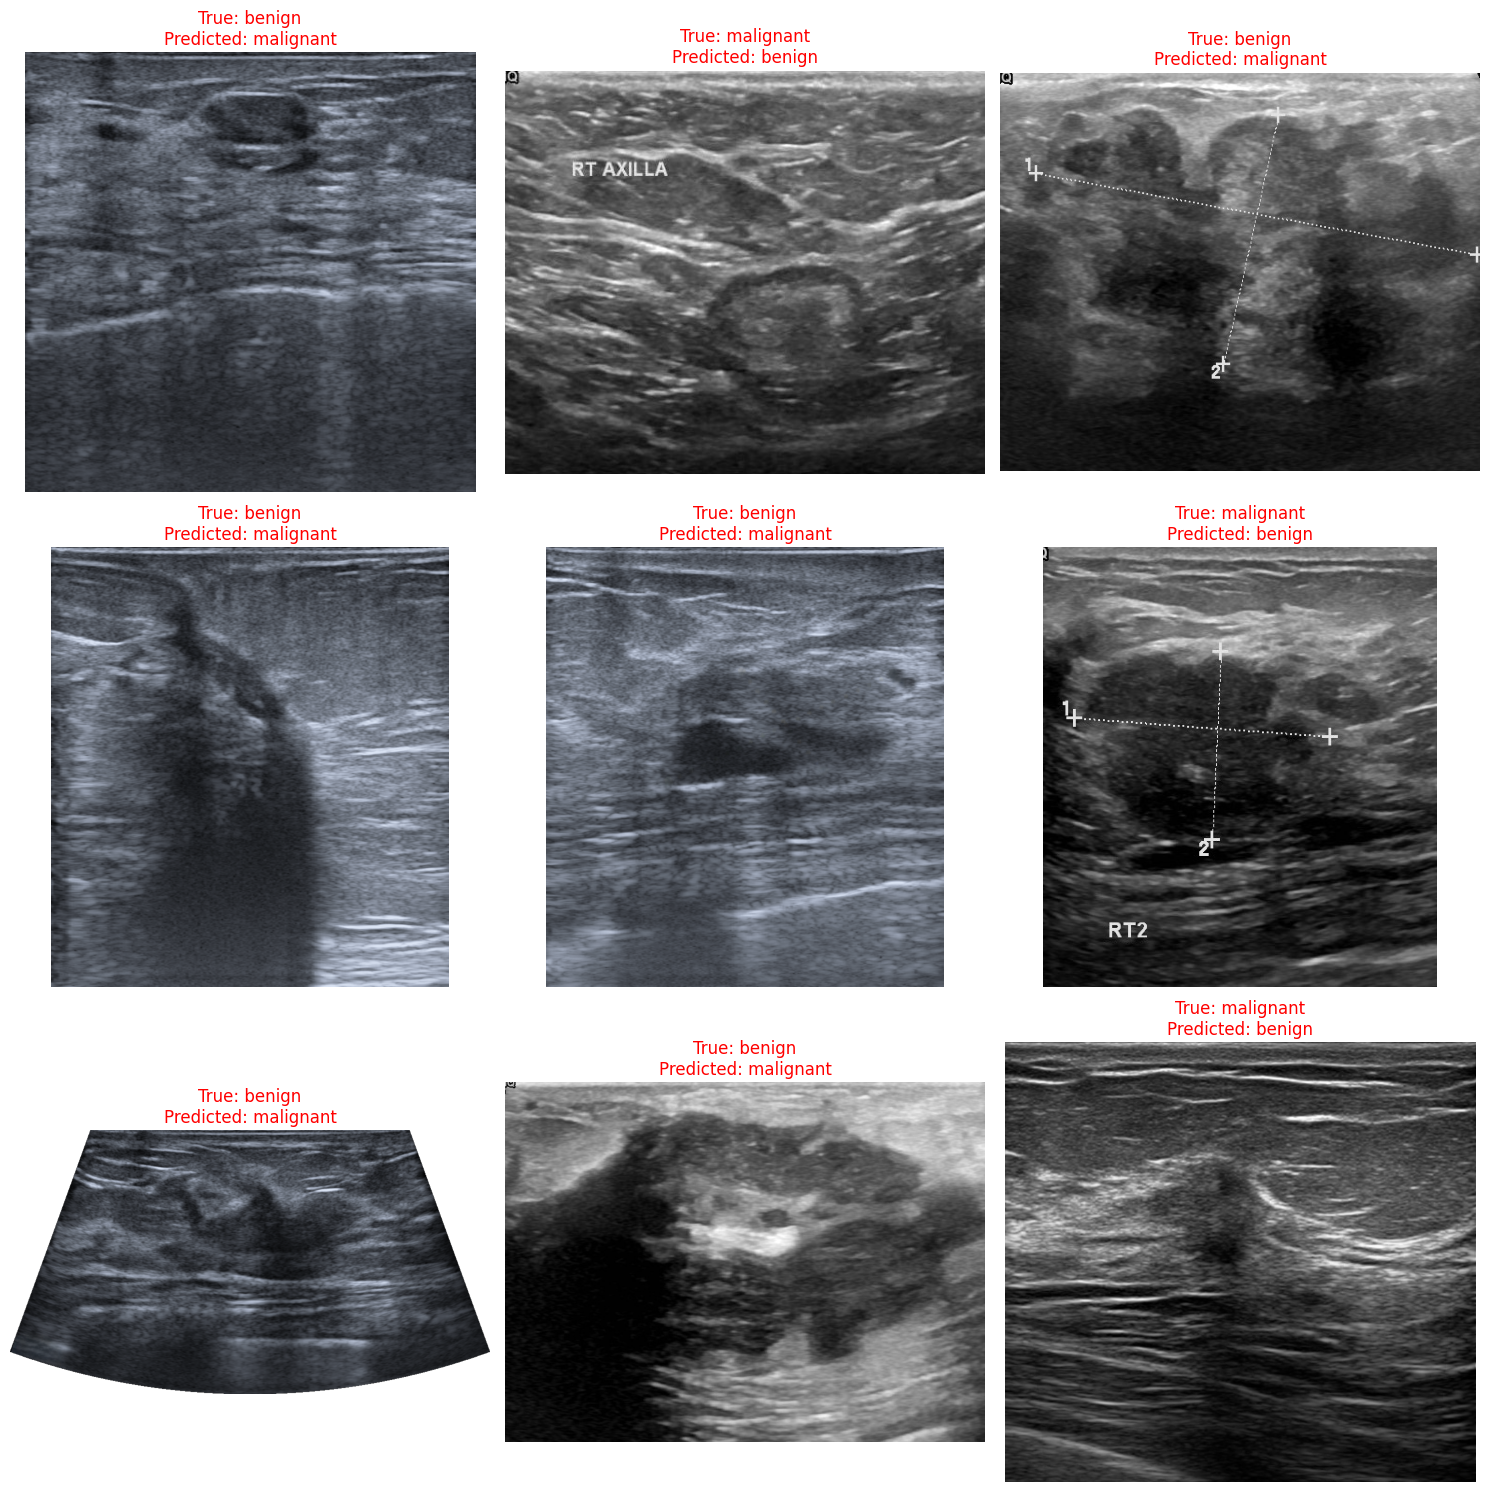

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Get the ground truth labels and corresponding file paths
test_generator.reset()  # Ensure the generator starts from the beginning
ground_truth_labels = test_generator.classes
file_paths = test_generator.filepaths
class_labels = list(test_generator.class_indices.keys())  # Map indices to class labels

# Get predictions from the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Identify incorrect predictions
incorrect_indices = np.where(predicted_classes != ground_truth_labels)[0]

print(f"Number of incorrect predictions: {len(incorrect_indices)}")

# Function to display images
def display_images(indices, file_paths, true_labels, predicted_labels, num_images=9):
    num_images = min(len(indices), num_images)  # Show at most `num_images`
    plt.figure(figsize=(15, 15))

    for i, index in enumerate(indices[:num_images]):
        filepath = file_paths[index]
        true_label = class_labels[true_labels[index]]
        predicted_label = class_labels[predicted_labels[index]]
        
        # Load and plot the image
        img = plt.imread(filepath)
        plt.subplot(3, 3, i + 1)  # Create a grid of 3x3 images
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color="red")

    plt.tight_layout()
    plt.show()

# Display a few incorrect predictions
display_images(incorrect_indices, file_paths, ground_truth_labels, predicted_classes)


# Model 2:Efficient netB7 

In [27]:
# Use EffiecinetNet

from tensorflow.keras.applications.efficientnet import preprocess_input
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_CLASSES = len(df['labels'].unique())

# Define data generators
train_datagen = ImageDataGenerator(
    #rescale=1.0/255.0,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generate batches of data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 189 validated image filenames belonging to 2 classes.
Found 81 validated image filenames belonging to 2 classes.


In [30]:
# Load EfficientNetB7 as base model
efficient_model = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3)
                           )

# # Freeze all layers first
# for layer in base_model.layers:
#     layer.trainable = False

# Unfreeze the top few layers
for layer in efficient_model.layers[-25:]:
    layer.trainable = True


In [31]:
# Create the input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass the input through the base model (DenseNet121)
x = efficient_model(inputs, training=False)

# Global Average Pooling to reduce the spatial dimensions
x = layers.GlobalAveragePooling2D()(x)

# # Batch Normalization for faster training
# x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu')(x)

# Dropout for regularization
x = layers.Dropout(0.5)(x)

# Output layer with softmax activation (for multi-class classification)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create the final model
second_model = models.Model(inputs, outputs)

In [32]:
second_model.compile(optimizer=Adam(learning_rate=0.0001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])


In [33]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# Train the model with class weights and early stopping
history = second_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/20
20/20 [==============================] - 483s 21s/step - loss: 0.6761 - accuracy: 0.5644 - val_loss: 0.5807 - val_accuracy: 0.7249
Epoch 2/20
20/20 [==============================] - 408s 20s/step - loss: 0.5652 - accuracy: 0.6820 - val_loss: 0.4135 - val_accuracy: 0.8148
Epoch 3/20
20/20 [==============================] - 409s 20s/step - loss: 0.4302 - accuracy: 0.8203 - val_loss: 0.3901 - val_accuracy: 0.8360
Epoch 4/20
20/20 [==============================] - 408s 20s/step - loss: 0.3877 - accuracy: 0.8251 - val_loss: 0.3351 - val_accuracy: 0.8730
Epoch 5/20
20/20 [==============================] - 402s 20s/step - loss: 0.3002 - accuracy: 0.8776 - val_loss: 0.3751 - val_accuracy: 0.8413
Epoch 6/20
20/20 [==============================] - 401s 20s/step - loss: 0.2804 - accuracy: 0.8728 - val_loss: 0.3276 - val_accuracy: 0.8677
Epoch 7/20
20/20 [==============================] - 402s 20s/step - loss: 0.2579 - accuracy: 0.8935 - val_loss: 0.3508 - val_accuracy: 0.8254
Epoch 

In [37]:
test_loss, test_accuracy = second_model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 12s 3s/step - loss: 0.3493 - accuracy: 0.8642
Test Loss: 0.3493
Test Accuracy: 0.8642


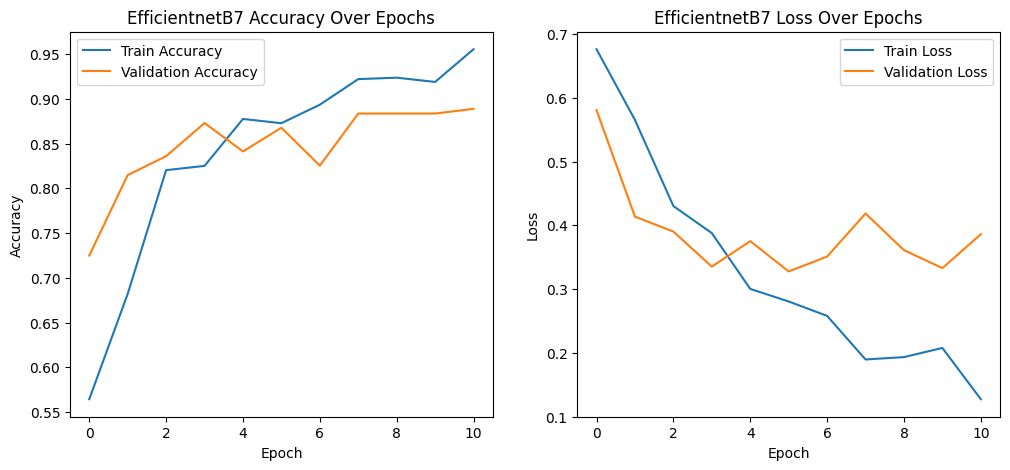

In [38]:
# Plot training vs validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('EfficientnetB7 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training vs validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('EfficientnetB7 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

6/6 [==============================] - 26s 4s/step


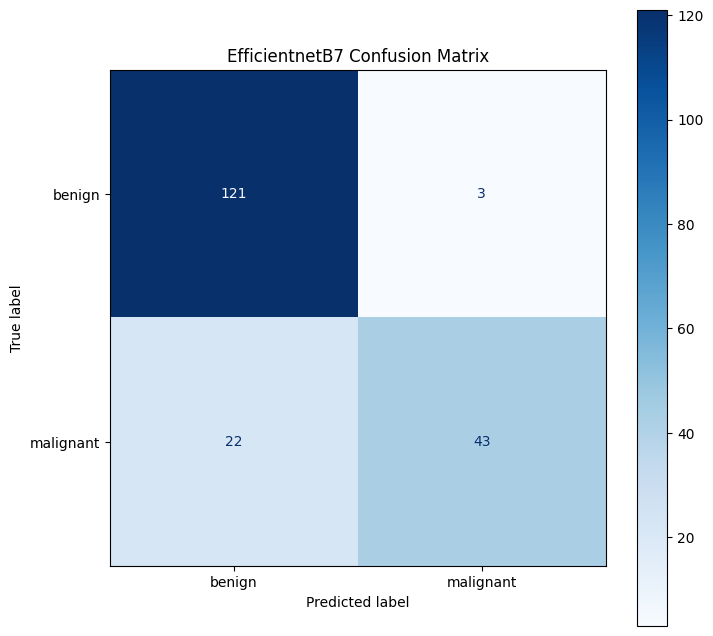

EfficientnetB7 Classification Report:
               precision    recall  f1-score   support

      benign       0.85      0.98      0.91       124
   malignant       0.93      0.66      0.77        65

    accuracy                           0.87       189
   macro avg       0.89      0.82      0.84       189
weighted avg       0.88      0.87      0.86       189



In [39]:

# Predict the labels for the validation data
predictions = second_model.predict(val_generator, verbose=1)

# Get the true labels from the validation generator
true_classes = val_generator.classes

# Convert the predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Define class labels (modify these according to your dataset)
class_labels = val_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}  # Invert the dictionary
class_labels = [class_labels[i] for i in range(len(class_labels))]

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')

# Add title
plt.title('EfficientnetB7 Confusion Matrix')
plt.show()

# Generate and display the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("EfficientnetB7 Classification Report:\n", report)